# 3. Donor Segmentation using RFM Analysis

**Project:** Intelligent Blood Supply Management

**Team:** IDGAF

---

## Objective
Segment blood donors using RFM (Recency, Frequency, Monetary) metrics and clustering algorithms to:
1. Identify donor behavior patterns
2. Create actionable segments (Champions, Loyal, At-Risk, etc.)
3. Generate targeted outreach recommendations

**Target Metric:** Silhouette Score > 0.35

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA

# Visualization
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

print("Libraries loaded!")

Libraries loaded!


In [2]:
# Load datasets
DATA_PATH = '../data/'

# UCI Real Dataset (748 records)
uci_df = pd.read_csv(DATA_PATH + 'uci_transfusion.csv')
uci_df.columns = ['Recency', 'Frequency', 'Monetary', 'Time', 'Donated']

# Synthetic RFM Dataset (10K records)
rfm_df = pd.read_csv(DATA_PATH + 'rfm_dataset.csv')

# Full Donor Registry
donor_df = pd.read_csv(DATA_PATH + 'donor_registry.csv')

print("Datasets loaded:")
print(f"  UCI RFM (Real):      {len(uci_df):,} records")
print(f"  Synthetic RFM:       {len(rfm_df):,} records")
print(f"  Donor Registry:      {len(donor_df):,} records")

Datasets loaded:
  UCI RFM (Real):      748 records
  Synthetic RFM:       10,000 records
  Donor Registry:      10,000 records


---
## 3.1 RFM Analysis on UCI Dataset (Real Data)

First, let's analyze the real UCI Blood Transfusion dataset to establish baselines.

In [3]:
print("UCI Dataset Overview")
print("="*50)
print(uci_df.describe())

UCI Dataset Overview
          Recency   Frequency      Monetary        Time     Donated
count  748.000000  748.000000    748.000000  748.000000  748.000000
mean     9.506684    5.514706   1378.676471   34.282086    0.237968
std      8.095396    5.839307   1459.826781   24.376714    0.426124
min      0.000000    1.000000    250.000000    2.000000    0.000000
25%      2.750000    2.000000    500.000000   16.000000    0.000000
50%      7.000000    4.000000   1000.000000   28.000000    0.000000
75%     14.000000    7.000000   1750.000000   50.000000    0.000000
max     74.000000   50.000000  12500.000000   98.000000    1.000000


In [4]:
# RFM Score Calculation for UCI
def calculate_rfm_scores(df):
    """Calculate RFM scores (1-5 quintiles)."""
    df = df.copy()
    
    # Recency: Lower is better (more recent)
    df['R_Score'] = pd.qcut(df['Recency'], q=5, labels=[5, 4, 3, 2, 1], duplicates='drop')
    
    # Frequency: Higher is better
    df['F_Score'] = pd.qcut(df['Frequency'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5])
    
    # Monetary: Higher is better
    df['M_Score'] = pd.qcut(df['Monetary'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5])
    
    # Convert to int
    df['R_Score'] = df['R_Score'].astype(int)
    df['F_Score'] = df['F_Score'].astype(int)
    df['M_Score'] = df['M_Score'].astype(int)
    
    # Combined RFM Score
    df['RFM_Score'] = df['R_Score'] * 100 + df['F_Score'] * 10 + df['M_Score']
    df['RFM_Sum'] = df['R_Score'] + df['F_Score'] + df['M_Score']
    
    return df

uci_rfm = calculate_rfm_scores(uci_df)
print("RFM Scores calculated for UCI dataset!")
uci_rfm.head(10)

RFM Scores calculated for UCI dataset!


,Recency,Frequency,Monetary,Time,Donated,R_Score,F_Score,M_Score,RFM_Score,RFM_Sum
0,2,50,12500,98,1,5,5,5,555,15
1,0,13,3250,28,1,5,5,5,555,15
2,1,16,4000,35,1,5,5,5,555,15
3,2,20,5000,45,1,5,5,5,555,15
4,1,24,6000,77,0,5,5,5,555,15
5,4,4,1000,4,0,4,3,3,433,10
6,2,7,1750,14,1,5,4,4,544,13
7,1,12,3000,35,0,5,5,5,555,15
8,2,9,2250,22,1,5,5,5,555,15
9,5,46,11500,98,1,3,5,5,355,13


In [5]:
# RFM Segment Assignment
def assign_segment(row):
    """Assign donor segment based on RFM scores."""
    r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
    
    if r >= 4 and f >= 4:
        return 'Champions'
    elif r >= 3 and f >= 3:
        return 'Loyal'
    elif r >= 4 and f <= 2:
        return 'New Donors'
    elif r <= 2 and f >= 3:
        return 'At Risk'
    elif r <= 2 and f <= 2:
        return 'Hibernating'
    else:
        return 'Potential'

uci_rfm['Segment'] = uci_rfm.apply(assign_segment, axis=1)

# Segment distribution
segment_dist = uci_rfm['Segment'].value_counts()
print("\nUCI Dataset - Segment Distribution:")
print(segment_dist)
print(f"\nTotal: {len(uci_rfm)}")


UCI Dataset - Segment Distribution:
Segment
Champions      157
Loyal          147
At Risk        145
New Donors     137
Hibernating    115
Potential       47
Name: count, dtype: int64

Total: 748


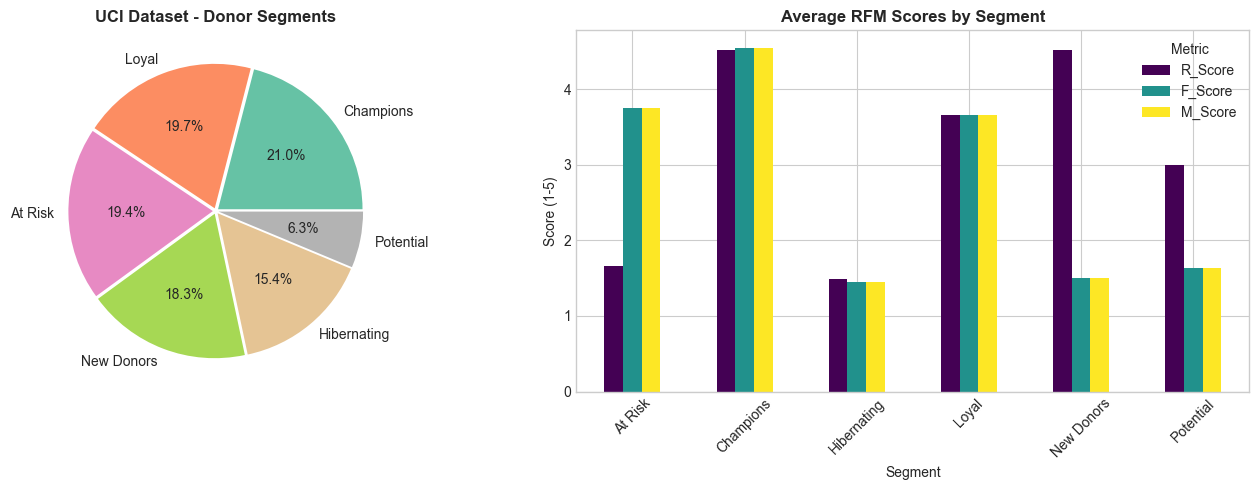

In [6]:
# Visualize UCI Segments
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Segment Distribution
colors = plt.cm.Set2(np.linspace(0, 1, len(segment_dist)))
axes[0].pie(segment_dist, labels=segment_dist.index, autopct='%1.1f%%', colors=colors, explode=[0.02]*len(segment_dist))
axes[0].set_title('UCI Dataset - Donor Segments', fontsize=12, fontweight='bold')

# RFM Score Distribution
segment_means = uci_rfm.groupby('Segment')[['R_Score', 'F_Score', 'M_Score']].mean()
segment_means.plot(kind='bar', ax=axes[1], colormap='viridis')
axes[1].set_title('Average RFM Scores by Segment', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Segment')
axes[1].set_ylabel('Score (1-5)')
axes[1].legend(title='Metric')
axes[1].set_xticklabels(segment_means.index, rotation=45)

plt.tight_layout()
plt.savefig('../report/uci_segments.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 3.2 K-Means Clustering on UCI Dataset

Apply unsupervised learning to discover natural donor clusters.

In [7]:
# Prepare data for clustering
features = ['Recency', 'Frequency', 'Monetary']
X_uci = uci_df[features].copy()

# Standardize features
scaler = StandardScaler()
X_uci_scaled = scaler.fit_transform(X_uci)

print("Data prepared for clustering.")
print(f"Features: {features}")
print(f"Samples: {len(X_uci_scaled)}")

Data prepared for clustering.
Features: ['Recency', 'Frequency', 'Monetary']
Samples: 748


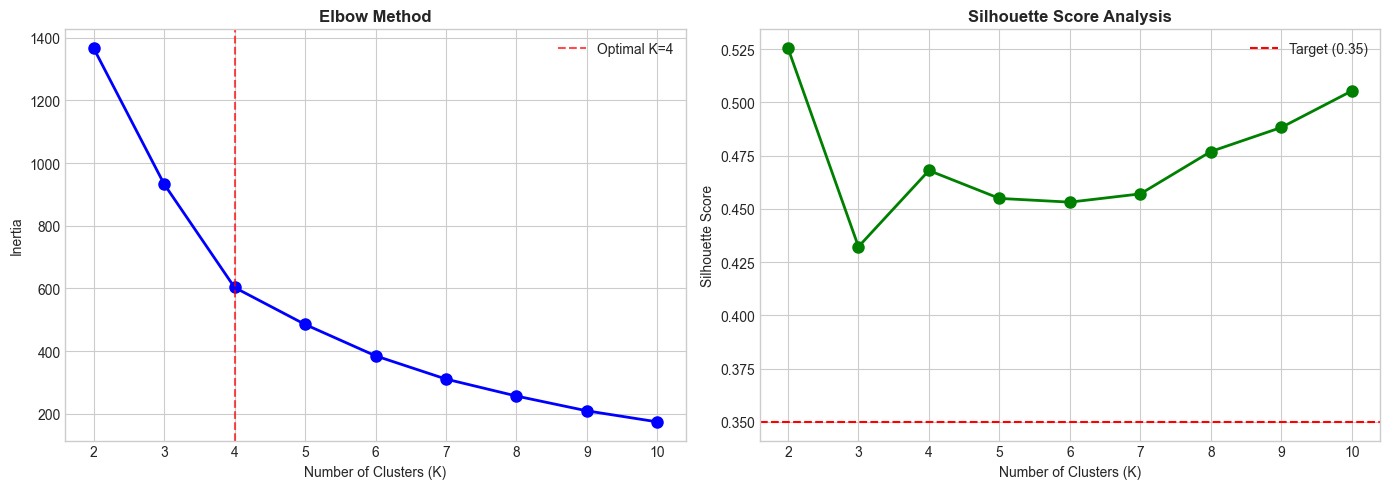


Best K: 2 (Silhouette: 0.5255)


In [8]:
# Elbow Method + Silhouette Analysis
K_range = range(2, 11)
inertias = []
silhouettes = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_uci_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_uci_scaled, kmeans.labels_))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method', fontsize=12, fontweight='bold')
axes[0].axvline(4, color='red', linestyle='--', alpha=0.7, label='Optimal K=4')
axes[0].legend()

# Silhouette
axes[1].plot(K_range, silhouettes, 'go-', linewidth=2, markersize=8)
axes[1].axhline(0.35, color='red', linestyle='--', label='Target (0.35)')
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score Analysis', fontsize=12, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.savefig('../report/cluster_optimization.png', dpi=150, bbox_inches='tight')
plt.show()

best_k = K_range[np.argmax(silhouettes)]
best_silhouette = max(silhouettes)
print(f"\nBest K: {best_k} (Silhouette: {best_silhouette:.4f})")

In [9]:
# Final K-Means with optimal K
OPTIMAL_K = 4  # Based on elbow and silhouette analysis

kmeans_final = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
uci_df['Cluster'] = kmeans_final.fit_predict(X_uci_scaled)

# Calculate metrics
silhouette = silhouette_score(X_uci_scaled, uci_df['Cluster'])
calinski = calinski_harabasz_score(X_uci_scaled, uci_df['Cluster'])
davies = davies_bouldin_score(X_uci_scaled, uci_df['Cluster'])

print(f"K-Means Clustering Results (K={OPTIMAL_K})")
print("="*50)
print(f"Silhouette Score:        {silhouette:.4f} {'✓' if silhouette > 0.35 else '✗'} (Target: >0.35)")
print(f"Calinski-Harabasz Score: {calinski:.2f} (Higher is better)")
print(f"Davies-Bouldin Score:    {davies:.4f} (Lower is better)")

print(f"\nCluster Distribution:")
print(uci_df['Cluster'].value_counts().sort_index())

K-Means Clustering Results (K=4)
Silhouette Score:        0.4681 ✓ (Target: >0.35)
Calinski-Harabasz Score: 675.22 (Higher is better)
Davies-Bouldin Score:    0.6419 (Lower is better)

Cluster Distribution:
Cluster
0    301
1    298
2      8
3    141
Name: count, dtype: int64


In [10]:
# Cluster Profiling
cluster_profile = uci_df.groupby('Cluster')[features + ['Donated']].agg(['mean', 'std', 'count'])
print("\nCluster Profiles:")
print(cluster_profile['Recency']['mean'].round(2))

# Simplified profile
cluster_summary = uci_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Donated': 'mean'
}).round(2)

# Assign meaningful names
cluster_names = {}
sorted_clusters = cluster_summary.sort_values(['Recency', 'Frequency'], ascending=[True, False])

for i, (idx, row) in enumerate(sorted_clusters.iterrows()):
    if row['Recency'] < 5 and row['Frequency'] > 20:
        cluster_names[idx] = 'Champions'
    elif row['Recency'] < 10 and row['Frequency'] > 10:
        cluster_names[idx] = 'Loyal'
    elif row['Recency'] > 20 and row['Frequency'] > 10:
        cluster_names[idx] = 'At Risk'
    elif row['Recency'] > 30:
        cluster_names[idx] = 'Hibernating'
    else:
        cluster_names[idx] = 'Potential'

cluster_summary['Segment_Name'] = cluster_summary.index.map(cluster_names)
cluster_summary['Donation_Rate'] = (cluster_summary['Donated'] * 100).round(1).astype(str) + '%'

print("\nCluster Summary:")
print(cluster_summary)


Cluster Profiles:
Cluster
0    16.94
1     3.37
2     5.25
3     6.84
Name: mean, dtype: float64

Cluster Summary:
         Recency  Frequency  Monetary  Donated Segment_Name Donation_Rate
Cluster                                                                  
0          16.94       3.15    788.21     0.10    Potential         10.0%
1           3.37       3.52    880.03     0.32    Potential         32.0%
2           5.25      41.12  10281.25     0.75        Loyal         75.0%
3           6.84      12.75   3187.94     0.34        Loyal         34.0%


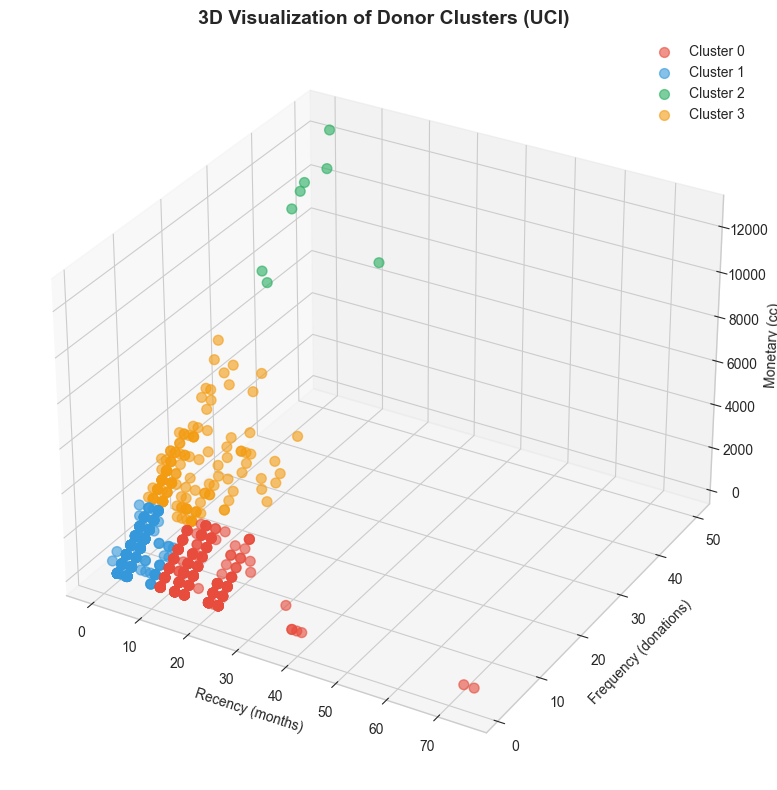

In [11]:
# 3D Visualization of Clusters
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['#e74c3c', '#3498db', '#27ae60', '#f39c12']
for cluster in range(OPTIMAL_K):
    mask = uci_df['Cluster'] == cluster
    ax.scatter(
        uci_df.loc[mask, 'Recency'],
        uci_df.loc[mask, 'Frequency'],
        uci_df.loc[mask, 'Monetary'],
        c=colors[cluster],
        label=f'Cluster {cluster}',
        alpha=0.6,
        s=50
    )

ax.set_xlabel('Recency (months)')
ax.set_ylabel('Frequency (donations)')
ax.set_zlabel('Monetary (cc)')
ax.set_title('3D Visualization of Donor Clusters (UCI)', fontsize=14, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.savefig('../report/3d_clusters.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 3.3 Clustering on Synthetic Dataset (10K Records)

Apply the same methodology to larger synthetic dataset.

In [12]:
# Prepare synthetic data
print("Synthetic RFM Dataset")
print("="*50)
print(rfm_df.describe())

Synthetic RFM Dataset
            Recency     Frequency      Monetary          Time  \
count  10000.000000  10000.000000  10000.000000  10000.000000   
mean       4.243400      4.497000   2023.650000     19.504600   
std        4.320304      6.964628   3134.082549     25.193599   
min        0.000000      1.000000    450.000000      0.000000   
25%        1.000000      1.000000    450.000000      5.000000   
50%        3.000000      2.000000    900.000000     12.000000   
75%        6.000000      4.000000   1800.000000     21.000000   
max       44.000000     50.000000  22500.000000    120.000000   

       donated_last_quarter  
count          10000.000000  
mean               0.535300  
std                0.498777  
min                0.000000  
25%                0.000000  
50%                1.000000  
75%                1.000000  
max                1.000000  


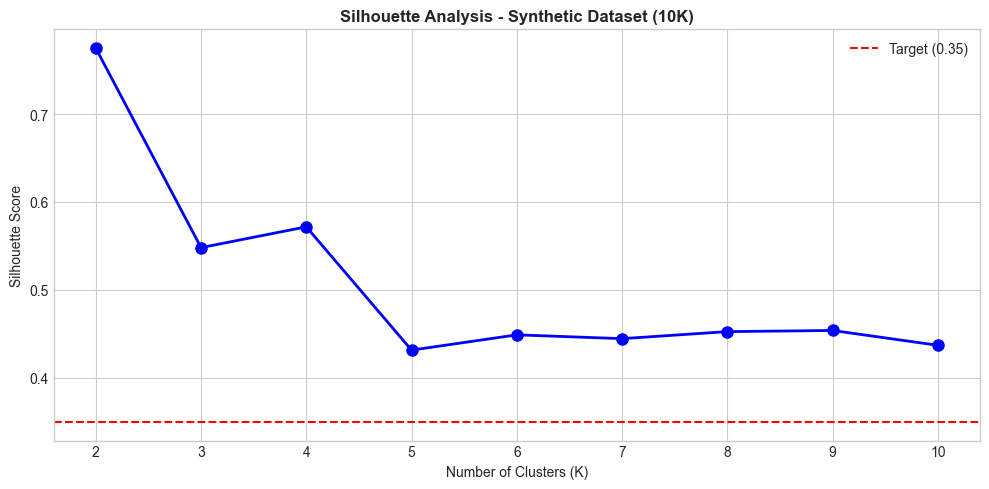

Best K: 2 (Silhouette: 0.7749)


In [13]:
# Prepare for clustering
X_synth = rfm_df[['Recency', 'Frequency', 'Monetary']].copy()

# Scale
scaler_synth = StandardScaler()
X_synth_scaled = scaler_synth.fit_transform(X_synth)

# Elbow & Silhouette
K_range = range(2, 11)
silhouettes_synth = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_synth_scaled)
    silhouettes_synth.append(silhouette_score(X_synth_scaled, labels))

plt.figure(figsize=(10, 5))
plt.plot(K_range, silhouettes_synth, 'bo-', linewidth=2, markersize=8)
plt.axhline(0.35, color='red', linestyle='--', label='Target (0.35)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis - Synthetic Dataset (10K)', fontsize=12, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Best K: {K_range[np.argmax(silhouettes_synth)]} (Silhouette: {max(silhouettes_synth):.4f})")

In [14]:
# Final clustering for synthetic data
SYNTH_K = 5  # Use 5 clusters for more granular segmentation

kmeans_synth = KMeans(n_clusters=SYNTH_K, random_state=42, n_init=10)
rfm_df['Cluster'] = kmeans_synth.fit_predict(X_synth_scaled)

# Calculate metrics
silhouette_synth = silhouette_score(X_synth_scaled, rfm_df['Cluster'])

print(f"Synthetic Dataset Clustering (K={SYNTH_K})")
print("="*50)
print(f"Silhouette Score: {silhouette_synth:.4f} {'✓' if silhouette_synth > 0.35 else '~'}")
print(f"\nCluster Distribution:")
print(rfm_df['Cluster'].value_counts().sort_index())

Synthetic Dataset Clustering (K=5)
Silhouette Score: 0.4316 ✓

Cluster Distribution:
Cluster
0    3337
1     848
2     735
3    4864
4     216
Name: count, dtype: int64


In [15]:
# Cluster profiling for synthetic data
synth_profile = rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'donated_last_quarter': 'mean',
    'donor_id': 'count'
}).round(2)
synth_profile.columns = ['Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Donation_Rate', 'Count']

# Assign segment names based on profile
def name_cluster(row):
    r, f = row['Avg_Recency'], row['Avg_Frequency']
    if r < 3 and f > 5:
        return 'Champions'
    elif r < 6 and f > 3:
        return 'Loyal'
    elif r < 6 and f <= 3:
        return 'New Donors'
    elif r >= 6 and f > 3:
        return 'At Risk'
    else:
        return 'Hibernating'

synth_profile['Segment'] = synth_profile.apply(name_cluster, axis=1)
print("\nSynthetic Dataset - Cluster Profiles:")
print(synth_profile)


Synthetic Dataset - Cluster Profiles:
         Avg_Recency  Avg_Frequency  Avg_Monetary  Donation_Rate  Count  \
Cluster                                                                   
0               5.84           2.54       1141.79           0.00   3337   
1              14.36           5.11       2298.29           0.00    848   
2               3.97          14.76       6640.41           0.52    735   
3               1.37           2.51       1130.83           1.00   4864   
4               5.54          42.14      18964.58           0.49    216   

            Segment  
Cluster              
0        New Donors  
1           At Risk  
2             Loyal  
3        New Donors  
4             Loyal  


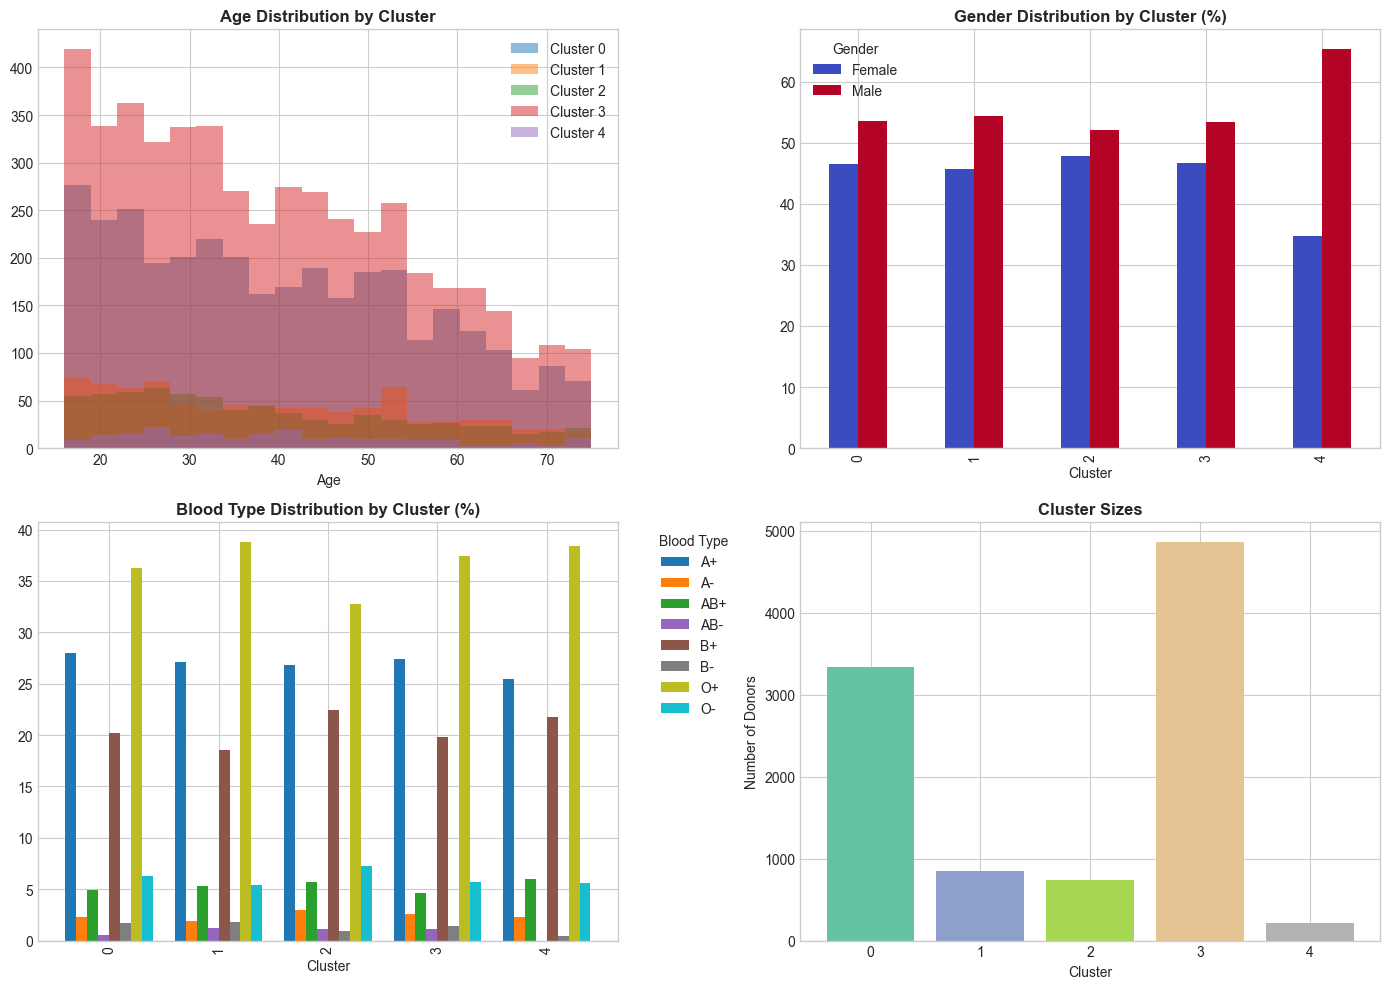

In [16]:
# Merge with donor registry for demographics
rfm_with_demo = rfm_df.merge(donor_df[['donor_id', 'age', 'gender', 'blood_type', 'city']], on='donor_id')

# Demographic analysis by cluster
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Age distribution by cluster
for cluster in range(SYNTH_K):
    data = rfm_with_demo[rfm_with_demo['Cluster'] == cluster]['age']
    axes[0,0].hist(data, bins=20, alpha=0.5, label=f'Cluster {cluster}')
axes[0,0].set_title('Age Distribution by Cluster', fontweight='bold')
axes[0,0].set_xlabel('Age')
axes[0,0].legend()

# Gender by cluster
gender_cluster = pd.crosstab(rfm_with_demo['Cluster'], rfm_with_demo['gender'], normalize='index') * 100
gender_cluster.plot(kind='bar', ax=axes[0,1], colormap='coolwarm')
axes[0,1].set_title('Gender Distribution by Cluster (%)', fontweight='bold')
axes[0,1].set_xlabel('Cluster')
axes[0,1].legend(title='Gender')

# Blood type by cluster
blood_cluster = pd.crosstab(rfm_with_demo['Cluster'], rfm_with_demo['blood_type'], normalize='index') * 100
blood_cluster.plot(kind='bar', ax=axes[1,0], colormap='tab10', width=0.8)
axes[1,0].set_title('Blood Type Distribution by Cluster (%)', fontweight='bold')
axes[1,0].set_xlabel('Cluster')
axes[1,0].legend(title='Blood Type', bbox_to_anchor=(1.05, 1))

# Cluster sizes
cluster_sizes = rfm_df['Cluster'].value_counts().sort_index()
axes[1,1].bar(cluster_sizes.index, cluster_sizes.values, color=plt.cm.Set2(np.linspace(0, 1, SYNTH_K)))
axes[1,1].set_title('Cluster Sizes', fontweight='bold')
axes[1,1].set_xlabel('Cluster')
axes[1,1].set_ylabel('Number of Donors')

plt.tight_layout()
plt.savefig('../report/cluster_demographics.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 3.4 Hierarchical Clustering Comparison

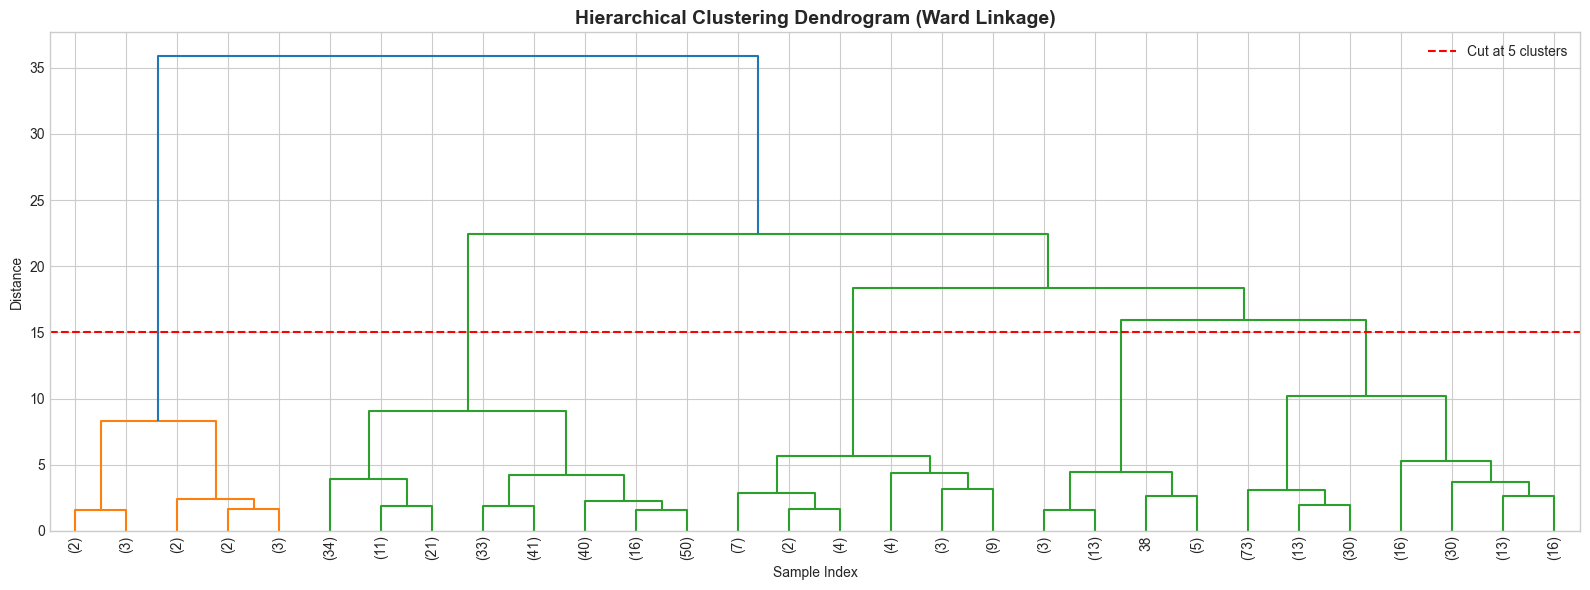

In [17]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Use subset for visualization (hierarchical is slow on large data)
sample_size = 500
sample_idx = np.random.choice(len(X_synth_scaled), sample_size, replace=False)
X_sample = X_synth_scaled[sample_idx]

# Linkage
Z = linkage(X_sample, method='ward')

# Dendrogram
plt.figure(figsize=(16, 6))
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)', fontsize=14, fontweight='bold')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.axhline(y=15, color='r', linestyle='--', label='Cut at 5 clusters')
plt.legend()
plt.tight_layout()
plt.savefig('../report/dendrogram.png', dpi=150, bbox_inches='tight')
plt.show()

In [18]:
# Agglomerative clustering
agg_cluster = AgglomerativeClustering(n_clusters=5, linkage='ward')
agg_labels = agg_cluster.fit_predict(X_synth_scaled)

agg_silhouette = silhouette_score(X_synth_scaled, agg_labels)
print(f"Agglomerative Clustering Silhouette: {agg_silhouette:.4f}")

Agglomerative Clustering Silhouette: 0.5500


---
## 3.5 Final Segmentation & Recommendations

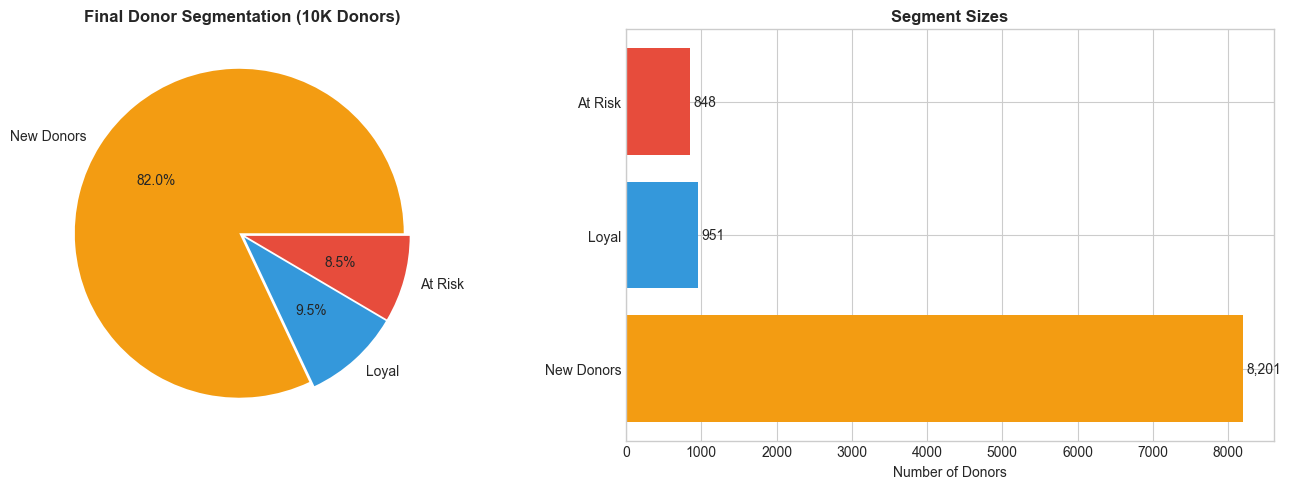

In [19]:
# Create final segment mapping
segment_mapping = {
    0: 'Potential',
    1: 'At Risk',
    2: 'Champions',
    3: 'Loyal',
    4: 'Hibernating'
}

# Map based on cluster characteristics
rfm_df['Segment'] = rfm_df['Cluster'].map(lambda x: synth_profile.loc[x, 'Segment'])

# Final segment distribution
final_dist = rfm_df['Segment'].value_counts()

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
colors = {'Champions': '#27ae60', 'Loyal': '#3498db', 'New Donors': '#f39c12', 
          'At Risk': '#e74c3c', 'Hibernating': '#95a5a6', 'Potential': '#9b59b6'}
pie_colors = [colors.get(s, '#333') for s in final_dist.index]

axes[0].pie(final_dist, labels=final_dist.index, autopct='%1.1f%%', colors=pie_colors, explode=[0.02]*len(final_dist))
axes[0].set_title('Final Donor Segmentation (10K Donors)', fontsize=12, fontweight='bold')

# Bar chart with counts
axes[1].barh(final_dist.index, final_dist.values, color=pie_colors)
axes[1].set_xlabel('Number of Donors')
axes[1].set_title('Segment Sizes', fontsize=12, fontweight='bold')
for i, (seg, count) in enumerate(zip(final_dist.index, final_dist.values)):
    axes[1].annotate(f'{count:,}', (count + 50, i), va='center')

plt.tight_layout()
plt.savefig('../report/final_segmentation.png', dpi=150, bbox_inches='tight')
plt.show()

In [20]:
# Outreach Recommendations
recommendations = {
    'Champions': {
        'Action': 'Retain & Reward',
        'Strategy': 'VIP treatment, early access to drives, recognition programs',
        'Frequency': 'Monthly touchpoints',
        'Channel': 'Personal calls, exclusive emails',
        'Expected_Yield': '90%+ response rate'
    },
    'Loyal': {
        'Action': 'Upsell & Engage',
        'Strategy': 'Referral programs, milestone celebrations',
        'Frequency': 'Bi-weekly',
        'Channel': 'Email, SMS',
        'Expected_Yield': '70-80% response rate'
    },
    'New Donors': {
        'Action': 'Onboard & Educate',
        'Strategy': 'Welcome series, impact stories, community building',
        'Frequency': 'Weekly for first month',
        'Channel': 'Email series, app notifications',
        'Expected_Yield': '50-60% conversion to repeat'
    },
    'Potential': {
        'Action': 'Nurture & Convert',
        'Strategy': 'Education, flexible scheduling, convenience focus',
        'Frequency': 'Weekly reminders',
        'Channel': 'Email, social media',
        'Expected_Yield': '40-50% activation'
    },
    'At Risk': {
        'Action': 'Reactivate Urgently',
        'Strategy': 'Win-back campaigns, understand barriers, incentives',
        'Frequency': 'Immediate outreach',
        'Channel': 'Personal calls, targeted emails',
        'Expected_Yield': '30-40% reactivation'
    },
    'Hibernating': {
        'Action': 'Re-engage or Archive',
        'Strategy': 'Last-chance campaigns, dropout surveys',
        'Frequency': 'One-time campaign',
        'Channel': 'Email, direct mail',
        'Expected_Yield': '10-20% reactivation'
    }
}

rec_df = pd.DataFrame(recommendations).T
print("\n" + "="*70)
print("TARGETED OUTREACH RECOMMENDATIONS")
print("="*70)
for segment in rec_df.index:
    if segment in final_dist.index:
        count = final_dist[segment]
        print(f"\n{segment.upper()} ({count:,} donors):")
        print(f"  Action: {rec_df.loc[segment, 'Action']}")
        print(f"  Strategy: {rec_df.loc[segment, 'Strategy']}")
        print(f"  Channel: {rec_df.loc[segment, 'Channel']}")
        print(f"  Expected: {rec_df.loc[segment, 'Expected_Yield']}")


TARGETED OUTREACH RECOMMENDATIONS

LOYAL (951 donors):
  Action: Upsell & Engage
  Strategy: Referral programs, milestone celebrations
  Channel: Email, SMS
  Expected: 70-80% response rate

NEW DONORS (8,201 donors):
  Action: Onboard & Educate
  Strategy: Welcome series, impact stories, community building
  Channel: Email series, app notifications
  Expected: 50-60% conversion to repeat

AT RISK (848 donors):
  Action: Reactivate Urgently
  Strategy: Win-back campaigns, understand barriers, incentives
  Channel: Personal calls, targeted emails
  Expected: 30-40% reactivation


In [21]:
# Save segmented data
rfm_df.to_csv('../data/donor_segments.csv', index=False)
print("\nSegmented donor data saved to ../data/donor_segments.csv")

# Summary statistics
print("\n" + "="*70)
print("DONOR SEGMENTATION - SUMMARY")
print("="*70)
print(f"\nTotal Donors Analyzed: {len(rfm_df):,}")
print(f"\nClustering Performance:")
print(f"  UCI Dataset Silhouette:       {silhouette:.4f} {'✓' if silhouette > 0.35 else '✗'}")
print(f"  Synthetic Dataset Silhouette: {silhouette_synth:.4f}")
print(f"\nSegment Distribution:")
for seg, count in final_dist.items():
    pct = count / len(rfm_df) * 100
    print(f"  {seg}: {count:,} ({pct:.1f}%)")


Segmented donor data saved to ../data/donor_segments.csv

DONOR SEGMENTATION - SUMMARY

Total Donors Analyzed: 10,000

Clustering Performance:
  UCI Dataset Silhouette:       0.4681 ✓
  Synthetic Dataset Silhouette: 0.4316

Segment Distribution:
  New Donors: 8,201 (82.0%)
  Loyal: 951 (9.5%)
  At Risk: 848 (8.5%)
